<a href="https://colab.research.google.com/github/ayportella/02_data_analytics/blob/main/17_exploratory_data_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br> 
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A Loggi é uma empresa brasileira de logística com know-how tecnológico que atua principalmente no setor de e-commerce, e realiza coletas de encomendas para grandes, médias e pequenas empresas, e tem também parcerias com entregadores autônomos.

Em 2019 a startup foi avaliada em mais de US$ 1 bilhão em 2019, entrando para a lista de unicórnios brasileiros.

Em 2020, por conta da pandemia da Covid-19, o e-commerce cresceu significativamente, e a Loggi cresceu 360% em relação ao ano anterior.

Essa é uma análise exploratória de um problema acerca de pontos de entrega de encomendas e hubs de distribuição nas regiões administrativas do Distrito Federal, a fim de otimizar as entregas em 3 regiões. Recebemos um dado bruto e devemos fazer a exploração dos dados, manipulação, controle e visualização dos dados, com geração de insights e interpretações dos gráficos de maneira a melhor entender como as concentrações de entrega se dão a partir da localização dos hubs.

## 2\. Pacotes e bibliotecas

In [ ]:
!pip3 install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import numpy as np
import pandas as pd
import geopandas
import geopy
from geopy.geocoders import Nominatim 
from geopy.extra.rate_limiter import RateLimiter
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns


## 3\. Exploração de dados

In [ ]:
#download do dado bruto 
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

#dado bruto no formato de dicionário
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [ ]:
#exploração para saber o tamanho do dado
len(data)

199

In [ ]:
# explorando a primeira linha
example = data[0]
print(example)

{'name': 'cvrp-2-df-33', 'region': 'df-2', 'origin': {'lng': -48.05498915846707, 'lat': -15.83814451122274}, 'vehicle_capacity': 180, 'deliveries': [{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'point': {'lng': -48.11618888384239, 'lat': -15.848929154862294}, 'size': 9}, {'id': '320c94b17aa685c939b3f3244c3099de', 'point': {'lng': -48.11819489551, 'lat': -15.850772371049631}, 'size': 2}, {'id': '3663b42f4b8decb33059febaba46d5c8', 'point': {'lng': -48.11248339849675, 'lat': -15.84787055941764}, 'size': 1}, {'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'point': {'lng': -48.11802268617869, 'lat': -15.846471025281456}, 'size': 2}, {'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'point': {'lng': -48.114898174591026, 'lat': -15.85805462185708}, 'size': 7}, {'id': '71271df40c3188cda88266f9969a5a9', 'point': {'lng': -48.120447632397045, 'lat': -15.8477803198514}, 'size': 10}, {'id': 'be0cd4bee278b16f3473c8fb05e96464', 'point': {'lng': -48.121801874785255, 'lat': -15.852089389271015}, 'size': 7}, {'id': 'e

In [ ]:
# quais são as colunas do dado no momento?
print(example.keys())

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])


**3.1 Wrangling**

In [ ]:
# dado bruto no pandas
deliveries_df = pd.DataFrame(data)

In [ ]:
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Percebe-se que a coluna 'origin' e 'deliveries'contém dados nested ou aninhados na estrutura JSON. 
Primeiro, iremos normalizar a coluna origin com uma operação conhecida como flattening, ou achatamento, que tranforma cada chave em uma nova coluna.

Organizando a coluna 'origin'

In [ ]:
#coluna origin
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


In [ ]:
# após realizar o achatamento, vamos juntar os dois DataFrames
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


Excluindo a coluna 'origin' e reorganizando a ordem das colunas restantes:

In [ ]:
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.head()

,name,region,lng,lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Renomeando as colunas de latitude e longitude para ficar claro que se trata da localização do hub:





In [ ]:
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Com a coluna 'deliveries, que possui uma estrutura mais complexa que origim. usaremos um outro tipo de operação conhecido como 'explode'. O 'explode' tranforma cada elemento da lista em uma linha. Por fim, faremos o método 'flatten' do resultado da coluna.

In [ ]:
#usando explode
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()


,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [ ]:
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis=1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Com os dados explodidos, vamos normalizá-los para combiná-los ao conjunto de dados principal:

---



In [ ]:
len(deliveries_exploded_df)

636149

In [ ]:
len(deliveries_df)

199

In [ ]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [ ]:
deliveries_df.head(n=5)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


Agora com os dados estruturados e normalizados, iremos conhecer melhor a estrutura desse conjunto:

**3.2 Estrutura**

In [ ]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


**3.4 Schema**

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


**Atributos categóricos**

In [ ]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


**Atributos numéricos** 

In [ ]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [ ]:
#hubs com mais entregas

frequencia_hub_df = deliveries_df.groupby('region')
frequencia_hub_df = frequencia_hub_df.size().reset_index(name='counts')
frequencia_hub_df.sort_values(by=['counts'], ascending=False)

,region,counts
1,df-1,304708
2,df-2,261319
0,df-0,70122


Percebe-se que a região df-1 possui mais entregas, seguida da df-2, enquanto que a região df-3 tem um número bem abaixo de entregas quando comparadas com as outras duas.

**3.5 Dados Faltantes**

Verificando se existem dados faltantes, que podem ser vazios (""), nulos (None) Não disponíveis ou aplicáveis (na, NA, etc), não numérico (nan, NaN, NAN, etc):

In [ ]:
#verificando quais colunas possuem dados faltantes
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 4\. Manipulação

**4.1 Enriquecimento**

Agora que já temos várias informações sobre nossos dados, vamos enriquecê-lo fazendo a **geocodificação reversa** do hub e das entregas.

A geocodificação é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A geocodificação reversa faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Empresas como Google, Bing e Yahoo! fornecem geocodificação como serviço (e cobram por isso). Existe uma projeto open source chamado de OpenStreetMap que mantém um serviço gratuito de geocodificação chamado **Nominatim**, serviço este que apresenta como limitação a quantia de uma única consuta por segundo. Vamos utilizá-lo através do pacote Python **geopy** para fazer a operação reversa e enriquecer o nosso DataFrame principal.

In [ ]:
import geopy
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 68906480,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright",
  "osm_type": "node",
  "osm_id": 6456379935,
  "lat": "-15.656819",
  "lon": "-47.8019514",
  "display_name": "Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "amenity": "Clinica dos Olhos",
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state": "Distrito Federal",
    "ISO3166-2-lvl4": "BR-DF",
    "region": "Região Centro-Oeste",
    "postcod

Aplicando a geocodificação nas coordenadas das três regiões e extraindo informações de 'cidade' e 'bairro'.

In [ ]:
from geopy.extra.rate_limiter import RateLimiter
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

Criando uma nova coluna chamada 'coordinates' com latitude e longitude 

In [ ]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,68906480,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,138610967,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,67585484,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


Montando as colunas "hub_suburb" e 'hub_city' para que não exista coluna de endereço com conteúdo não preenchido (NaN):

In [ ]:
import numpy as np

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


O DataFrame hub_geodata_df com as informações de 'cidade' e 'bairro' é então combinado ao DataFrame principal deliveries_df, enriquecendo o dado anterior:

In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


**Geocodificação reversa da entrega**



Enquanto o **hub** contem apenas **3** geolocalizações distintas, as **entregas** somam o total de **636.149** geolocalizações, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, dada a restrição de uma consulta por segundo. Contudo, para cargas pesadas como esta, o software oferece uma instalação local (na sua própria máquina) que pode ser utilizada sem restrição.

Porém como a instalação não era o escopo desse projeto, os dados foram obtidos a partir do link abaixo, em que o dado já segue disponilizado:

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv 

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


**Vamos acrescentar uma coluna com a distância entre o Hub de origem e o destino das encomendas**



Para isso, utilizaremos o pacote Haversine.

In [ ]:
deliveries_df["distance_hub_delivery_km"] = deliveries_df.index
deliveries_df["distance_hub_delivery_km"] = deliveries_df["distance_hub_delivery_km"].apply(lambda d: haversine((deliveries_df['hub_lat'][d], deliveries_df['hub_lng'][d]),
                                                                                                          (deliveries_df['delivery_lat'][d], deliveries_df['delivery_lng'][d])))
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance_hub_delivery_km
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018


**Vamos acrescentar uma coluna com gasto de gasolina por distância percorrida**

 Aqui, vamos imaginar que o veículo utilizado na entrega é um carro do modelo Fiorino Furgão 2018 1.4, que faz até 10,5km/L. Claro que o modelo do veículo utilizado pela Loggi pode ser outro. A ideia aqui é somente ter uma noção geral do gasto com combustível.

Segundo a Agência Nacional do Petróleo, Gás, e Biocombustíveis (ANP), o preço médio da gasolina está custando R$ 4,98 no Brasil, com dados de coleta entre os dias 30/10/22 a 05/11/2022. É em cima desse valor que vamos realizar o cálculo.

In [ ]:
deliveries_df['spent_on_gas'] = (4.98/10.5)*deliveries_df['distance_hub_delivery_km']

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance_hub_delivery_km,spent_on_gas
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516,3.156616
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410,3.275137
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588,2.961719
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062,3.228018
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018,3.215666


**4.2 Schema**

Sobre a qualidade dos dados que foram acrescentados:

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   name                      636149 non-null  object 
 1   region                    636149 non-null  object 
 2   hub_lng                   636149 non-null  float64
 3   hub_lat                   636149 non-null  float64
 4   hub_city                  636149 non-null  object 
 5   hub_suburb                636149 non-null  object 
 6   vehicle_capacity          636149 non-null  int64  
 7   delivery_size             636149 non-null  int64  
 8   delivery_lng              636149 non-null  float64
 9   delivery_lat              636149 non-null  float64
 10  delivery_city             634447 non-null  object 
 11  delivery_suburb           476264 non-null  object 
 12  distance_hub_delivery_km  636149 non-null  float64
 13  spent_on_gas              636149 non-null  f

In [ ]:
deliveries_df.isna().any()

name                        False
region                      False
hub_lng                     False
hub_lat                     False
hub_city                    False
hub_suburb                  False
vehicle_capacity            False
delivery_size               False
delivery_lng                False
delivery_lat                False
delivery_city                True
delivery_suburb              True
distance_hub_delivery_km    False
spent_on_gas                False
dtype: bool

## 5\. Visualização

Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte link para criar o DataFrame mapa. Note a coluna geometry.

In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


**Mapa dos Hubs**

Criando o DataFrame 'geo_hub_df' através do DataFrame 'deliveries_df'. Note a nova coluna 'geometry'.

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


**Mapa das Entregas**

Vamos criar o DataFrame geo_deliveries_df através do DataFrame deliveries_df. Note a nova coluna geometry.

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance_hub_delivery_km,spent_on_gas,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516,3.156616,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410,3.275137,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588,2.961719,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062,3.228018,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018,3.215666,POINT (-48.11490 -15.85805)


**Visualização**

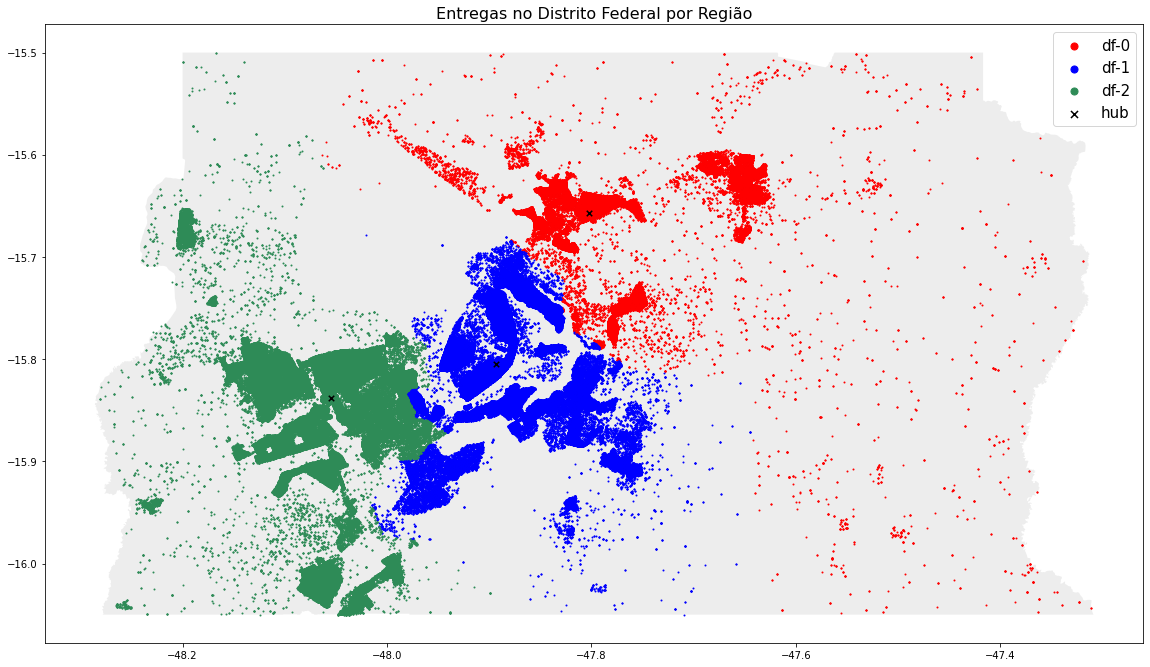

In [ ]:
import matplotlib.pyplot as plt

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

**Insights:**

Os hubs encontram-se posicionados em locais centrais de onde há maior concentração de cada região, o que é favorável para que a maior parte das entregas seja feita de maneira mais rápida.

As regiões com maiores pontos de entregas estão localizados em locais de maiores índices de IDH e PIB, o que condiz com o maior volume de entregas para esses locais. 

Ceilândia, a região administrativa mais populosa do DF localizada no extremo oeste, tem poucos pontos de entrega e seu Hub não está localizado próximo, o que reafirma o insight anterior, uma vez que ocupa o 22o lugar na lista de renda per capita segundo a Pesquisa Distrital por Amostra de Domicílio 2018 da CODEPLAN.



**Gráfico de entregas por região**

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


**Visualização**

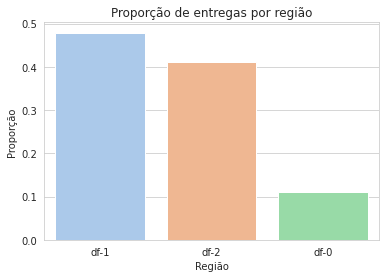

In [ ]:
import seaborn as sns

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

Insights

Há maior concentração de entregas nos hubs das regiões 1 e 2, e pouca no hub 0 (< 12% do total). Como a região df-0 é a menor em extensão total dentre as três áreas, pelo menos na região de maior concentração, pode-se dizer que a porcentagem de entrega é condizente com o restante dos locais, não sobrecarregando o sistema e trazendo eficiência para entrega em outros locais. 

Apesar disso, é  o hub com maior dispersão de pontos de entrega, o que pode ser preocupante dependendo do volume de entregas nesses pontos mais afastados.

**Quantidade de entregas por regiões administrativas de destino**

In [ ]:
data = pd.DataFrame(deliveries_df[['delivery_city']].value_counts()).reset_index()
data.rename(columns={0: "delivery_amount_per_city"}, inplace=True)
data.head()

,delivery_city,delivery_amount_per_city
0,Brasília,148983
1,Taguatinga,45564
2,Sudoeste / Octogonal,44215
3,Ceilândia,37953
4,Águas Claras,37083


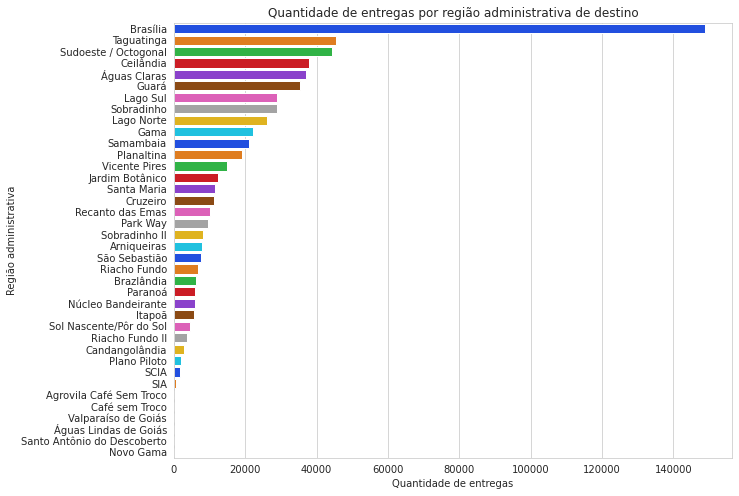

In [ ]:
with sns.axes_style('whitegrid'):
  plt.subplots(figsize=(10,8))
  grafico = sns.barplot(data=data, x='delivery_amount_per_city', y="delivery_city", ci=None, palette="bright")
  grafico.set(title='Quantidade de entregas por região administrativa de destino', xlabel='Quantidade de entregas', ylabel='Região administrativa');

A maior quantidade de entregas corresponde à região administrativa de Brasília, que está relacionada ao hub df-1, o que pode explicar a maior quantidade de veículos de entrega para esta região. Porém há uma quantidade considerável de entregas em outras regiões que não estão relacionadas ao hub df-1, o que pode ser problemático caso a demanda para essas regiões aumente.

**Média da distância entre os Hubs e os locais de entrega em km**

In [ ]:
data_mean_distance = deliveries_df[['region', 'distance_hub_delivery_km']].groupby('region', as_index=False).agg('mean').sort_values(by=['distance_hub_delivery_km'], ascending=False)
data_mean_distance = data_mean_distance.round(2)
data_mean_distance.head()

,region,distance_hub_delivery_km
0,df-0,9.02
2,df-2,7.90
1,df-1,5.96


Percebe-se que a região df-0, seguida da df-2, possuem os maiores valores médios para distâncias entre os hubs e os locais de entrega. Isso porque seus pontos de entrega encontram-se com alta dispersão quando comparados com o hub df-1.

**Média de gasto com gasolina por entrega**

In [ ]:
data_spent_gas = deliveries_df[['region', 'spent_on_gas']].groupby('region', as_index=False).agg('mean').sort_values(by=['spent_on_gas'], ascending=False)
data_spent_gas = data_spent_gas.round(2)
data_spent_gas.head()

,region,spent_on_gas
0,df-0,4.28
2,df-2,3.75
1,df-1,2.83


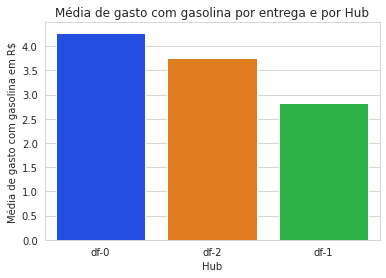

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data_spent_gas, x="region", y="spent_on_gas", ci=None, palette="bright")
  grafico.set(title='Média de gasto com gasolina por entrega e por Hub', xlabel='Hub', ylabel='Média de gasto com gasolina em R$');

Mesmo que o hub df-1 possua mais entregas que os outros dois, assim como uma frota maior de veículos, o gasto de gasolina no hub df-0 e df-2 são maiores, isso devido provavelmente à maior distância que precisam percorrer para entregar em pontos mais afastados de cada hub. De modo a equilibrar essa discrepância da média de gastos em cada hub, os veículos poderiam ser remobilizados do df-1 para os outros dois.

**Conclusão do Projeto de Exploração**

De acordo com os dados analisados, pode-se inferir que a região administrativa de Brasília, localizada no hub df-1, tem a maior quantidade de entregas dentre todas as regiões, o que é explicado por possuir maior renda per capita e corresponder à sede do Governo do Distrito Federal, lugar onde existe maior demanda por entregas e serviços.

Ainda assim, há uma quantidade considerável de entregas em outras regiões administrativas que não correspondem ao hub df-1, e que não possuem quantidade de veículos proporcional à região df-1. Os hubs df-0 e df-2 têm pontos de entrega mais dispersos, em que se deve percorrer mais para finalizar uma entrega, o que implica em maior gasto de gasolina e alocação de recursos pela empresa. Esta informação deve ser considerada em uma tomada de decisão da 
empresa a fim de gerenciar melhor os custos das entregas.
